# Debugging code

This notebook serves as  testbed for the code written in the separate python files. Here I test the different functions with their inputs and use possible error messages to debug. 

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# import code
from plotting import plotting
from riemann import riemann

In [2]:
# initialize necessary classes

mu = 1.0 # set to 1 for convenience
T = 1.0 # set to 1 for convenience

# Riemann initial conditions
rho_L = 1.  # x < 0
rho_R = 1.  # x > 0

v_L = 1
v_R = 0.

# insert momentum in U vector
U_L = (rho_L, v_L*rho_L)
U_R = (rho_R, v_R*rho_R)

plots = plotting(rho_L, rho_R, v_L, v_R)

## Plotting class
Here I will test the different plotting functionality I have added to this class.

In [3]:
def solve(rho_L, rho_R, v_L, v_R):
    plots = plotting(rho_L, rho_R, v_L, v_R)
    plots.full_solution()

{'1-wave': 'shock', '2-wave': 'shock'}


/Users/bertdepoorter/Nextcloud/Documents/School/Universiteit/CmpMethothods Astrophysics/Individual_CMfAA/riemann.py:125: RuntimeWarning: divide by zero encountered in log
  m = v_hat*rho_range - self.c_s * rho_range * np.log(rho_range / rho_hat)
/Users/bertdepoorter/Nextcloud/Documents/School/Universiteit/CmpMethothods Astrophysics/Individual_CMfAA/riemann.py:125: RuntimeWarning: invalid value encountered in multiply
  m = v_hat*rho_range - self.c_s * rho_range * np.log(rho_range / rho_hat)
/Users/bertdepoorter/Nextcloud/Documents/School/Universiteit/CmpMethothods Astrophysics/Individual_CMfAA/riemann.py:127: RuntimeWarning: divide by zero encountered in log
  m = v_hat*rho_range + self.c_s * rho_range * np.log(rho_range / rho_hat)
/Users/bertdepoorter/Nextcloud/Documents/School/Universiteit/CmpMethothods Astrophysics/Individual_CMfAA/riemann.py:127: RuntimeWarning: invalid value encountered in multiply
  m = v_hat*rho_range + self.c_s * rho_range * np.log(rho_range / rho_hat)


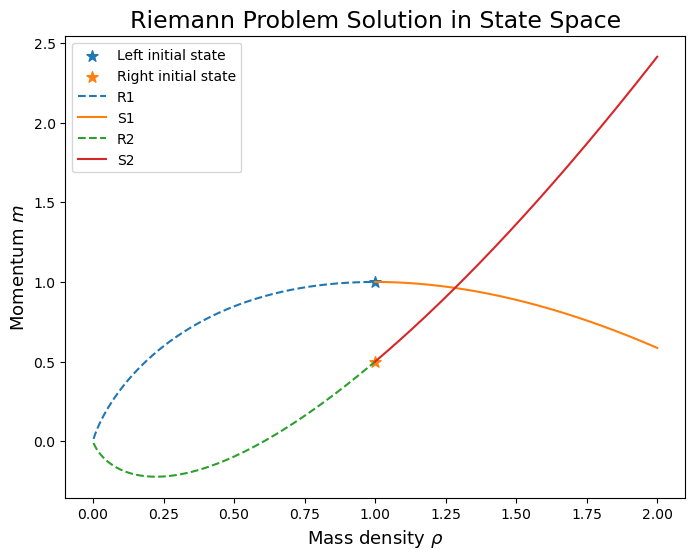

In [4]:
solve(1,1,1, 0.5)

In [ ]:
# plot hugoniot locus for left and right states
plots.plot_2_hugoniot_loci(U_L, U_R, intermediate=True)

In [ ]:
# we plot the Hugoniot locus for a given state U
title = "Hugoniot locus left"
plots.plot_Hugoniot_locus(U_L, title=title)

In [ ]:
# plot integrl curves
plots.plot_integral_curves(U_L, title='Integral curves Left')

In [ ]:
plots.plot_integral_curves(U_R, title='Integral curves Right')

In [ ]:
plots.plot_integral_hugoniot(U_L, 
                             title='Hugoniot locus vs. integral curve: Left',
                             name='Hugoniot_integral_left')

In [ ]:
plots.plot_integral_hugoniot(U_R, 
                             title='Hugoniot locus vs. integral curve: Right',
                             name='Hugoniot_integral_right')

We see that the integral curves do not even go through the initial state on whhich they are based. Likely there is something wrong with the domain of the parameters in U_R for this case. The figures seem to have similar behaviour, only there is a scaling factor or something like that missing.

Problem solved: we should keep in mind that U[1] is the momentum, so when we need the velocity we actually need U[1]/U[0].

In [ ]:
plots.plot_Hugoniot_locus_derivative(U_L,
                                    name='Hugoniot_curve_left')

In [ ]:
plots.plot_Hugoniot_locus_derivative(U_R,
                                    name='Hugoniot_curve_right')

In [ ]:
plots.Plot_Rankine_hugoniot_derivative(U_L,
                                      name='Hugoniot_rankine_derivative_left')

In [ ]:
plots.Plot_Rankine_hugoniot_derivative(U_R,
                                      name='Hugoniot_rankine_derivative_right')

### Plotting numerical solution

In [ ]:
plots.plot_numerical_solution('tvdlf', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                            )

This seems to go wrong very quickly: spurious oscillations rapidly develop, how should we deal with this?
The TVDLF scheme should normally be resistant against these oscillatory behaviour, especially with the minmod limiter. Probably there is something wrong there? 

Solution: maximal speed was badly defined in the calculation of the time step. So CFL condition was violated.

In [ ]:
# test maccormack scheme
plots.plot_numerical_solution('maccormack', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                              t_end=0.004
                            )

In [ ]:
# test upwind scheme
plots.plot_numerical_solution('upwind', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                              t_end=0.06
                            )

In [ ]:
plots.plot_numerical_state_space('tvdlf', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                              t_end=0.009
                            )

### Get analytic solution
test the decision tree I build

## solver class
This part is dedicated to testing the different solvers implemented. 

In [ ]:
riemann_model = riemann(rho_L, rho_R, v_L, v_R)

In [ ]:
# Plot each timestep
cfl=0.6
nx = 1000
c_s = 1

x = np.linspace(-1, 1, nx)
dx = x[1] - x[0]
vmax = abs(v_R)+ c_s
dt = cfl * dx / vmax  # CFL condition

In [ ]:
# initialize U: density and momentum vector
U = np.zeros((nx, 2))
mid = nx//2

# initialize left and right state with Riemann initial conditions
U[:mid, 0] = rho_L
U[:mid, 1] = v_L * rho_L
U[mid:, 0] = rho_R
U[mid:, 1] = v_R * rho_R

t = 0
time_max = 100*dt
k=0
while t< time_max:
    # employ 2 step predictor corrector method
    U_predictor = riemann_model.timestep(U, dx, dt, 'tvdlf', 'minmod')
    U = 1/2 * (U + riemann_model.timestep(U_predictor, dx, dt, 'tvdlf', 'minmod'))
    t+= dt
    k+= 1
    if k == 5:
        fig, ax = plt.subplots(1,1)
        ax.plot(x, U[:, 0], label='density')
        ax.plot(x, U[:,1]/U[:, 0], label='momentum')
        ax.legend()
        ax.set_title('time t = '+str(t))
        k=0

## First try solution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
c_s = 1.0  # Isothermal sound speed

# Function to calculate Hugoniot loci for a given state U (rho, v)
def compute_hugoniot_loci(rho_0, v_0, rho_range):
    loci = []
    for rho in rho_range:
        if rho != rho_0:
            delta_rho = rho - rho_0
            v_shock = v_0 + c_s * np.sqrt(delta_rho / rho_0) * (1 if delta_rho > 0 else -1)
            loci.append((rho, v_shock))
    return np.array(loci)

# Function to compute integral curves (rarefactions) for a given state U (rho, v)
def compute_integral_curves(rho_0, v_0, rho_range, wave_type):
    curves = []
    for rho in rho_range:
        if wave_type == '1-rarefaction':
            v = v_0 - c_s * np.log(rho / rho_0)
        elif wave_type == '2-rarefaction':
            v = v_0 + c_s * np.log(rho / rho_0)
        else:
            raise ValueError("Invalid wave type. Choose '1-rarefaction' or '2-rarefaction'.")
        curves.append((rho, v))
    return np.array(curves)

# Function to solve the Riemann problem and find intermediate state U*
def solve_riemann_problem(rho_L, v_L, rho_R, v_R):
    # Initialize guesses for the intermediate state
    rho_star = (rho_L + rho_R) / 2
    v_star = (v_L + v_R) / 2

    # Solve iteratively using conservation laws (not implemented in detail for simplicity)
    # Use Hugoniot loci and integral curves to refine estimates of rho_star and v_star
    # For this template, we return approximate values for demonstration purposes
    return rho_star, v_star

# Plot Hugoniot loci and integral curves
def plot_state_space(rho_L, v_L, rho_R, v_R):
    rho_range = np.linspace(0.1, 2.0, 500)

    # Compute loci and curves for left state
    hugoniot_L = compute_hugoniot_loci(rho_L, v_L, rho_range)
    rarefaction_1_L = compute_integral_curves(rho_L, v_L, rho_range, '1-rarefaction')

    # Compute loci and curves for right state
    hugoniot_R = compute_hugoniot_loci(rho_R, v_R, rho_range)
    rarefaction_2_R = compute_integral_curves(rho_R, v_R, rho_range, '2-rarefaction')

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot Hugoniot loci
    plt.plot(hugoniot_L[:, 0], hugoniot_L[:, 1], label='Hugoniot Loci (Left)', linestyle='--')
    plt.plot(hugoniot_R[:, 0], hugoniot_R[:, 1], label='Hugoniot Loci (Right)', linestyle='--')

    # Plot Integral Curves
    plt.plot(rarefaction_1_L[:, 0], rarefaction_1_L[:, 1], label='1-Rarefaction (Left)', linestyle=':')
    plt.plot(rarefaction_2_R[:, 0], rarefaction_2_R[:, 1], label='2-Rarefaction (Right)', linestyle=':')

    # Plot initial states
    plt.scatter([rho_L, rho_R], [v_L, v_R], color='red', label='Initial States')

    # Add labels and legend
    plt.xlabel('Density (rho)')
    plt.ylabel('Velocity (v)')
    plt.title('State Space: Hugoniot Loci and Integral Curves')
    plt.legend()
    plt.grid()
    plt.show()

# Main script to demonstrate the solution
if __name__ == "__main__":
    # Define left and right states (rho, v)
    rho_L, v_L = 1.0, 0.5
    rho_R, v_R = 0.5, -0.5

    # Solve Riemann problem
    rho_star, v_star = solve_riemann_problem(rho_L, v_L, rho_R, v_R)
    print(f"Intermediate State: rho* = {rho_star}, v* = {v_star}")

    # Plot state space
    plot_state_space(rho_L, v_L, rho_R, v_R)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
c_s = 1.0  # Isothermal sound speed

def solve_riemann_problem_numerically(method, limiter, timestepper):
    """
    Solves the 1D Riemann problem numerically using specified methods.

    input:
    - method (str): flux discretization method ('tvdlf', 'upwind', 'maccormack')
    - limiter (str): flux reconstruction limiter ('minmod', 'woodward')
    - timestepper (str): time integration scheme ('onestep', 'twostep')

    output:
    - Numerical solution for the Riemann problem.
    """
    def flux(U):
        """Compute the flux for the isothermal hydrodynamics system."""
        rho, momentum = U
        v = momentum / rho
        return np.array([rho * v, rho * v**2 + c_s**2 * rho])

    def apply_limiter(slope_L, slope_R, limiter):
        """Apply the chosen limiter to compute the reconstructed slope."""
        if limiter == 'minmod':
            return np.sign(slope_L) * np.maximum(0, np.minimum(abs(slope_L), abs(slope_R)))
        elif limiter == 'woodward':
            return np.maximum(0, np.minimum((slope_L + slope_R) / 2, 2 * slope_L, 2 * slope_R))
        else:
            raise ValueError("Invalid limiter. Choose 'minmod' or 'woodward'.")

    def timestep(U, dx, dt, method, limiter):
        """Advance the solution one time step using the chosen method."""
        nx = len(U)
        F_half = np.zeros((nx - 1, 2))

        # Compute fluxes at cell interfaces
        for i in range(nx - 1):
            # Compute slopes for limiters
            slope_L = U[i] - U[i - 1] if i > 0 else 0
            slope_R = U[i + 1] - U[i] if i < nx - 2 else 0
            limited_slope = apply_limiter(slope_L, slope_R, limiter)

            if method == 'tvdlf':
                max_lambda = max(abs(U[i][1] / U[i][0]) + c_s, abs(U[i + 1][1] / U[i + 1][0]) + c_s)
                F_half[i] = 0.5 * (flux(U[i]) + flux(U[i + 1]) - max_lambda * (U[i + 1] - U[i]))
            elif method == 'upwind':
                F_half[i] = flux(U[i])
            elif method == 'maccormack':
                # Predictor step (forward difference)
                predictor = U[i] - dt / dx * (flux(U[i + 1]) - flux(U[i]))
                # Corrector step (backward difference)
                F_half[i] = 0.5 * (flux(U[i]) + flux(predictor))
            else:
                raise ValueError("Invalid method. Choose 'tvdlf', 'upwind', or 'maccormack'.")

        # Update conserved variables
        U_new = U.copy()
        for i in range(1, nx - 1):
            U_new[i] -= dt / dx * (F_half[i] - F_half[i - 1])
        return U_new

    # Initial setup
    nx = 100
    x = np.linspace(0, 1, nx)
    dx = x[1] - x[0]
    dt = 0.5 * dx / c_s  # CFL condition

    # Initialize U (density and momentum)
    U = np.zeros((nx, 2))
    mid = nx // 2
    U[:mid, 0] = 1.0  # Left density
    U[:mid, 1] = 1.0 * 0.5  # Left momentum
    U[mid:, 0] = 0.5  # Right density
    U[mid:, 1] = 0.5 * -0.5  # Right momentum

    # Time integration
    t = 0
    t_end = 0.2
    while t < t_end:
        if timestepper == 'onestep':
            U = timestep(U, dx, dt, method, limiter)
        elif timestepper == 'twostep':
            # Perform a predictor-corrector step
            U_predictor = timestep(U, dx, dt, method, limiter)
            U = 0.5 * (U + timestep(U_predictor, dx, dt, method, limiter))
        else:
            raise ValueError("Invalid timestepper. Choose 'onestep' or 'twostep'.")
        t += dt

    # Extract final density and velocity
    rho = U[:, 0]
    v = U[:, 1] / rho
    return x, rho, v

# Main script to demonstrate the solution
if __name__ == "__main__":
    method = 'tvdlf'
    limiter = 'minmod'
    timestepper = 'onestep'

    # Solve Riemann problem numerically
    x, rho, v = solve_riemann_problem_numerically(method, limiter, timestepper)

    # Plot the results
    plt.figure(figsize=(10, 5))

    # Plot density
    plt.subplot(1, 2, 1)
    plt.plot(x, rho, label='Density')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Density Profile')
    plt.grid()
    plt.legend()

    # Plot velocity
    plt.subplot(1, 2, 2)
    plt.plot(x, v, label='Velocity', color='orange')
    plt.xlabel('x')
    plt.ylabel('Velocity')
    plt.title('Velocity Profile')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
